In [1]:
!pip install oandapyV20

^C
Traceback (most recent call last):
  File "/Users/Santi/anaconda3/bin/pip", line 7, in <module>
    from pip._internal import main
  File "/Users/Santi/anaconda3/lib/python3.7/site-packages/pip/_internal/__init__.py", line 40, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/Users/Santi/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/autocompletion.py", line 8, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/Users/Santi/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main_parser.py", line 12, in <module>
    from pip._internal.commands import (
  File "/Users/Santi/anaconda3/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 6, in <module>
    from pip._internal.commands.completion import CompletionCommand
  File "/Users/Santi/anaconda3/lib/python3.7/site-packages/pip/_internal/commands/completion.py", line 6, in <module>
    from pip._internal.cli.base_command import Command
 

In [3]:
import configparser
import json
from oandapyV20 import API    
import oandapyV20.endpoints.trades as trades

config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [4]:
# Get a list of all instruments 

import json
from oandapyV20 import API   
import oandapyV20.endpoints.accounts as accounts

client = API(access_token=config['oanda']['access_token'])
r = accounts.AccountInstruments(accountID=config['oanda']['account_id'])
rv = client.request(r)
print(json.dumps(rv, indent=2))

{
  "instruments": [
    {
      "name": "XAU_EUR",
      "type": "METAL",
      "displayName": "Gold/EUR",
      "pipLocation": -2,
      "displayPrecision": 3,
      "tradeUnitsPrecision": 0,
      "minimumTradeSize": "1",
      "maximumTrailingStopDistance": "100.000",
      "minimumTrailingStopDistance": "0.050",
      "maximumPositionSize": "0",
      "maximumOrderUnits": "50000",
      "marginRate": "0.1",
      "tags": [
        {
          "type": "ASSET_CLASS",
          "name": "COMMODITY"
        }
      ]
    },
    {
      "name": "UK100_GBP",
      "type": "CFD",
      "displayName": "UK 100",
      "pipLocation": 0,
      "displayPrecision": 1,
      "tradeUnitsPrecision": 0,
      "minimumTradeSize": "1",
      "maximumTrailingStopDistance": "10000.0",
      "minimumTrailingStopDistance": "5.0",
      "maximumPositionSize": "0",
      "maximumOrderUnits": "500",
      "marginRate": "0.1",
      "tags": [
        {
          "type": "ASSET_CLASS",
          "name": "INDE

In [5]:
# Extract Data from the Trading Website

import pandas as pd
import datetime
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments

params={"from": "2017-01-01",
        "to": "2017-07-10",
        "granularity":'D',
        "price":'A'}
r = instruments.InstrumentsCandles(instrument="DE30_EUR",params=params)
data = client.request(r)
results= [{"time":x['time'],"closeAsk":float(x['ask']['c'])} for x in data['candles']]
df = pd.DataFrame(results).set_index('time')

print(df)

                                closeAsk
time                                    
2017-01-02T22:00:00.000000000Z   11589.0
2017-01-03T22:00:00.000000000Z   11588.5
2017-01-04T22:00:00.000000000Z   11579.5
2017-01-05T22:00:00.000000000Z   11608.0
2017-01-08T22:00:00.000000000Z   11556.5
2017-01-09T22:00:00.000000000Z   11570.5
2017-01-10T22:00:00.000000000Z   11653.5
2017-01-11T22:00:00.000000000Z   11568.0
2017-01-12T22:00:00.000000000Z   11610.5
2017-01-15T22:00:00.000000000Z   11562.5
2017-01-16T22:00:00.000000000Z   11553.0
2017-01-17T22:00:00.000000000Z   11620.5
2017-01-18T22:00:00.000000000Z   11577.0
2017-01-19T22:00:00.000000000Z   11620.0
2017-01-22T22:00:00.000000000Z   11572.5
2017-01-23T22:00:00.000000000Z   11632.5
2017-01-24T22:00:00.000000000Z   11823.5
2017-01-25T22:00:00.000000000Z   11837.0
2017-01-26T22:00:00.000000000Z   11817.0
2017-01-29T22:00:00.000000000Z   11718.0
2017-01-30T22:00:00.000000000Z   11593.0
2017-01-31T22:00:00.000000000Z   11662.5
2017-02-01T22:00

In [6]:
# Define function that will create a signal to buy or sell

import pandas as pd
import numpy as np

def create_signals(data, MA1, MA2):
    signals = pd.DataFrame(index=data.index)
    signals['indication'] = 0.0
    
    signals['MovingA1'] = data.rolling(window = MA1).mean()
    signals['MovingA2'] = data.rolling(window = MA2).mean()
    
    signals['indication'] = np.where(signals['MovingA1'] > signals['MovingA2'], 1.0, 0.0)
    MAd=MA2-1
    signals['indication'] = signals['indication'][MAd:]
    signals['positions'] = signals['indication'].diff() 
    
    return signals.shift(1)
    
Cross=create_signals(df, 5, 20)


In [7]:
# Separate the buy and sell signals

Indexnames = Cross[Cross['positions'] == 0.0 ].index
cross = Cross.drop(Indexnames)

SIndexnames = cross[cross['positions'] == -1.0 ].index
Sellcross = cross.drop(SIndexnames)

BIndexnames = cross[cross['positions'] == 1.0 ].index
Buycross = cross.drop(BIndexnames)

In [8]:
# Format data before Plotting 

Buycross.index = pd.to_datetime(Buycross.index, dayfirst=True)
Sellcross.index = pd.to_datetime(Sellcross.index, dayfirst=True)
PositionsBuy = Buycross.dropna()
PositionsSell = Sellcross.dropna()

df.index=pd.to_datetime(df.index, dayfirst=True)


Text(0, 0.5, 'Price')

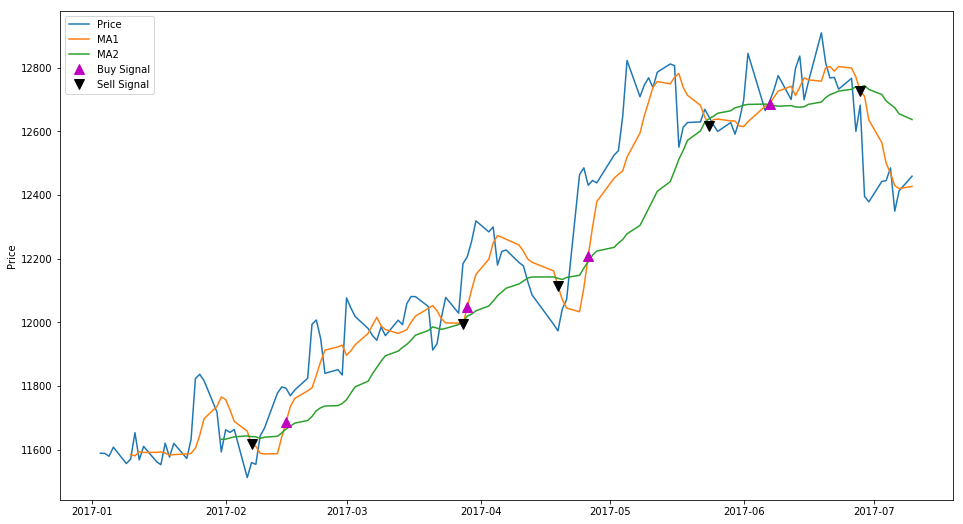

In [9]:
# Representation of the strategy 

import matplotlib.pyplot as plt

start_date = params['from']
end_date = params['to']

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(df.index, df.loc[start_date:end_date, 'closeAsk'], label='Price')
ax.plot(df.index, Cross.loc[start_date:end_date, 'MovingA1'], label = 'MA1')
ax.plot(df.index, Cross.loc[start_date:end_date, 'MovingA2'], label = 'MA2')
ax.plot(PositionsSell.index, PositionsSell['MovingA1'], '^', markersize=10, color='m', label = 'Buy Signal')
ax.plot(PositionsBuy.index, PositionsBuy['MovingA1'], 'v', markersize=10, color='k', label = 'Sell Signal')

ax.legend(loc='best')
ax.set_ylabel('Price')

In [8]:
# Calculating Portfolio value if following the strategy or not

Cross['closeAsk'] = df['closeAsk']
Cross['Return'] = np.log(Cross['closeAsk'] / Cross['closeAsk'].shift(1))
Cross['Return1'] = Cross['indication']*Cross['Return']

Cross['Return1'].fillna(0, inplace = True)
Cross['Return'].fillna(0, inplace = True)

Valuation = list(Cross['Return1'])
Valuation2 = list(Cross['Return'])

def Value(inital, returntype):
    sum1 =[]
    sum = inital
    for i in returntype:
        sum = sum + i*sum
        sum1.append(sum)
        
    return sum1


Cross['Valuation'] = Value(1000, Valuation)
Cross['Valuation2'] = Value(1000, Valuation2 )




Initial Value: 1000.0
Final value for buy and hold strategy: 1071.680109250024
Final value for our strategy: 993.8799286937775


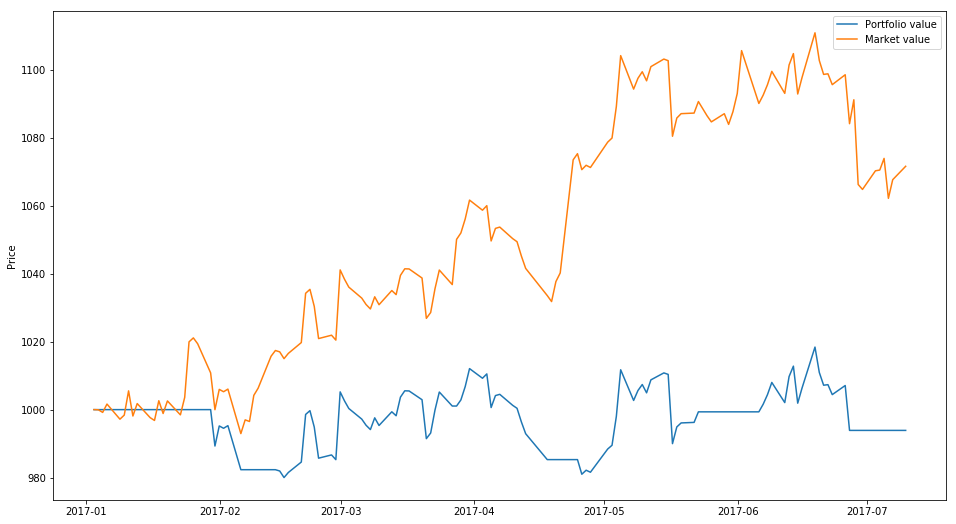

In [223]:
# Plotting Portfolio values

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(df.index, Cross.loc[start_date:end_date, 'Valuation'], label='Portfolio value')
ax.plot(df.index, Cross.loc[start_date:end_date, 'Valuation2'], label='Market value')

ax.legend(loc='best')
ax.set_ylabel('Price')

print('Initial Value:',Cross['Valuation'].iloc[0] )
print('Final value for buy and hold strategy:',Cross['Valuation2'].iloc[-1] )
print('Final value for our strategy:',Cross['Valuation'].iloc[-1] )

In [6]:
# Automated Trading

from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oandapyV20.exceptions import V20Error, StreamTerminated
        
class MomentumTrader(PricingStream): 
    def __init__(self, momentum, *args, **kwargs): 
        PricingStream.__init__(self, *args, **kwargs)
        self.ticks = 0 
        self.position = 0
        self.df = pd.DataFrame()
        self.momentum = momentum
        self.units = 100000
        self.connected = False
        self.client = API(access_token=config['oanda']['access_token'])
    def create_order(self, units):
        order = orders.OrderCreate(accountID=config['oanda']['account_id'], data=MarketOrderRequest(instrument="DE30_EUR", units=units).data)
        response = self.client.request(order)
        print('\t', response)
    def on_success(self, data):
        self.ticks += 1
        print("ticks=",self.ticks) # print(self.ticks, end=', ')
        self.df = self.df.append(pd.DataFrame([{'time': data['time'],'closeoutAsk':data['closeoutAsk']}],
                                 index=[data["time"]])) # appends the new tick data to the DataFrame object
        
        self.df.index = pd.DatetimeIndex(self.df["time"]) # transforms the time information to a DatetimeIndex object
        
        self.df['closeoutAsk'] = pd.to_numeric(self.df["closeoutAsk"],errors='ignore') # Convert items back to numeric (Why, OANDA, why are you returning strings?)
      
        dfr = self.df.resample('5s').last().bfill()   # resamples the data set to a new, homogeneous interval
        
        dfr['returns'] = np.log(dfr['closeoutAsk'] / dfr['closeoutAsk'].shift(1)) # calculates the log returns        
        
        dfr['position'] = np.sign(dfr['returns'].rolling(self.momentum).mean()) # derives the positioning according to the momentum strategy 
                                       
        print("position=",dfr['position'].iloc[-1])
        if dfr['position'].iloc[-1] == 1:
            print("go long")
            if self.position == 0:
                self.create_order(self.units)
            elif self.position == -1:
                self.create_order(self.units * 2)
            self.position = 1
        elif dfr['position'].iloc[-1] == -1:
            print("go short")
            if self.position == 0:
                self.create_order(-self.units)
            elif self.position == 1:
                self.create_order(-self.units * 2)
            self.position = -1
        if self.ticks == 120:
            print("close out the position")
            if self.position == 1:
                self.create_order(-self.units)
            elif self.position == -1:
                self.create_order(self.units)
            self.disconnect()
    def disconnect(self):
        self.connected=False
    def rates(self, account_id, instruments, **params):
        self.connected = True
        params = params or {}
        ignore_heartbeat = None
        if "ignore_heartbeat" in params:
            ignore_heartbeat = params['ignore_heartbeat']
        while self.connected:
            response = self.client.request(self)
            for tick in response:
                if not self.connected:
                    break
                if not (ignore_heartbeat and tick["type"]=="HEARTBEAT"):
                    print(tick)
                    self.on_success(tick)

In [7]:
mt = MomentumTrader(momentum=12,accountID=config['oanda']['account_id'],params={"instruments": "EUR_USD"})
mt.rates(account_id=config['oanda']['account_id'], instruments="EUR_USD", ignore_heartbeat=True)


{'type': 'PRICE', 'time': '2019-05-14T11:47:17.811095708Z', 'bids': [{'price': '1.12366', 'liquidity': 10000000}], 'asks': [{'price': '1.12380', 'liquidity': 10000000}], 'closeoutBid': '1.12351', 'closeoutAsk': '1.12395', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 1
position= nan
{'type': 'PRICE', 'time': '2019-05-14T11:47:24.397819323Z', 'bids': [{'price': '1.12369', 'liquidity': 10000000}], 'asks': [{'price': '1.12382', 'liquidity': 10000000}], 'closeoutBid': '1.12354', 'closeoutAsk': '1.12397', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 2
position= nan
{'type': 'PRICE', 'time': '2019-05-14T11:47:33.254194251Z', 'bids': [{'price': '1.12372', 'liquidity': 10000000}], 'asks': [{'price': '1.12384', 'liquidity': 10000000}], 'closeoutBid': '1.12357', 'closeoutAsk': '1.12399', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 3
position= nan
{'type': 'PRICE', 'time': '2019-05-14T11:47:52.333333474Z', 'bid

{'type': 'PRICE', 'time': '2019-05-14T11:49:02.852203478Z', 'bids': [{'price': '1.12362', 'liquidity': 10000000}], 'asks': [{'price': '1.12375', 'liquidity': 10000000}], 'closeoutBid': '1.12347', 'closeoutAsk': '1.12390', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 23
position= 1.0
go long
	 {'orderCreateTransaction': {'type': 'MARKET_ORDER', 'instrument': 'EUR_USD', 'units': '200000', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'reason': 'CLIENT_ORDER', 'id': '32', 'accountID': '101-004-11199400-001', 'userID': 11199400, 'batchID': '32', 'requestID': '24548430167396903', 'time': '2019-05-14T11:49:03.234353348Z'}, 'orderFillTransaction': {'type': 'ORDER_FILL', 'orderID': '32', 'instrument': 'EUR_USD', 'units': '200000', 'requestedUnits': '200000', 'price': '1.12375', 'pl': '0.0000', 'financing': '0.0000', 'commission': '0.0000', 'accountBalance': '99831.5991', 'gainQuoteHomeConversionFactor': '1.00723', 'lossQuoteHomeConversionFactor': '1.00739', 'gua

{'type': 'PRICE', 'time': '2019-05-14T11:49:39.336864494Z', 'bids': [{'price': '1.12347', 'liquidity': 10000000}], 'asks': [{'price': '1.12360', 'liquidity': 10000000}], 'closeoutBid': '1.12332', 'closeoutAsk': '1.12375', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 40
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-14T11:49:41.875704492Z', 'bids': [{'price': '1.12346', 'liquidity': 10000000}], 'asks': [{'price': '1.12357', 'liquidity': 10000000}], 'closeoutBid': '1.12331', 'closeoutAsk': '1.12372', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 41
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-14T11:49:46.531995110Z', 'bids': [{'price': '1.12348', 'liquidity': 10000000}], 'asks': [{'price': '1.12359', 'liquidity': 10000000}], 'closeoutBid': '1.12333', 'closeoutAsk': '1.12374', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 42
position= -1.0
go short
{'type': 'PRICE', 'time': '2019

{'type': 'PRICE', 'time': '2019-05-14T11:50:43.119203812Z', 'bids': [{'price': '1.12338', 'liquidity': 10000000}], 'asks': [{'price': '1.12350', 'liquidity': 10000000}], 'closeoutBid': '1.12323', 'closeoutAsk': '1.12365', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 66
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-14T11:51:08.222023163Z', 'bids': [{'price': '1.12336', 'liquidity': 10000000}], 'asks': [{'price': '1.12348', 'liquidity': 10000000}], 'closeoutBid': '1.12321', 'closeoutAsk': '1.12363', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 67
position= 1.0
go long
	 {'orderCreateTransaction': {'type': 'MARKET_ORDER', 'instrument': 'EUR_USD', 'units': '200000', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'reason': 'CLIENT_ORDER', 'id': '36', 'accountID': '101-004-11199400-001', 'userID': 11199400, 'batchID': '36', 'requestID': '24548430691917537', 'time': '2019-05-14T11:51:08.419444255Z'}, 'orderFillTransactio

{'type': 'PRICE', 'time': '2019-05-14T11:52:44.418428411Z', 'bids': [{'price': '1.12335', 'liquidity': 10000000}], 'asks': [{'price': '1.12348', 'liquidity': 10000000}], 'closeoutBid': '1.12320', 'closeoutAsk': '1.12363', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 83
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-14T11:52:48.017981724Z', 'bids': [{'price': '1.12333', 'liquidity': 10000000}], 'asks': [{'price': '1.12346', 'liquidity': 10000000}], 'closeoutBid': '1.12318', 'closeoutAsk': '1.12361', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 84
position= 1.0
go long
	 {'orderCreateTransaction': {'type': 'MARKET_ORDER', 'instrument': 'EUR_USD', 'units': '200000', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'reason': 'CLIENT_ORDER', 'id': '40', 'accountID': '101-004-11199400-001', 'userID': 11199400, 'batchID': '40', 'requestID': '24548431111533536', 'time': '2019-05-14T11:52:48.417968094Z'}, 'orderFillTransactio

{'type': 'PRICE', 'time': '2019-05-14T11:53:30.843234671Z', 'bids': [{'price': '1.12329', 'liquidity': 10000000}], 'asks': [{'price': '1.12341', 'liquidity': 10000000}], 'closeoutBid': '1.12314', 'closeoutAsk': '1.12356', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 100
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-14T11:53:53.711628236Z', 'bids': [{'price': '1.12331', 'liquidity': 10000000}], 'asks': [{'price': '1.12343', 'liquidity': 10000000}], 'closeoutBid': '1.12316', 'closeoutAsk': '1.12358', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 101
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-14T11:54:30.855488005Z', 'bids': [{'price': '1.12334', 'liquidity': 10000000}], 'asks': [{'price': '1.12344', 'liquidity': 10000000}], 'closeoutBid': '1.12319', 'closeoutAsk': '1.12359', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 102
position= 1.0
go long
	 {'orderCreateTransaction': {

{'type': 'PRICE', 'time': '2019-05-14T11:55:35.600174134Z', 'bids': [{'price': '1.12320', 'liquidity': 10000000}], 'asks': [{'price': '1.12332', 'liquidity': 10000000}], 'closeoutBid': '1.12305', 'closeoutAsk': '1.12347', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 117
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-14T11:55:42.054813777Z', 'bids': [{'price': '1.12322', 'liquidity': 10000000}], 'asks': [{'price': '1.12336', 'liquidity': 10000000}], 'closeoutBid': '1.12307', 'closeoutAsk': '1.12351', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 118
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-14T11:55:42.973686977Z', 'bids': [{'price': '1.12325', 'liquidity': 10000000}], 'asks': [{'price': '1.12338', 'liquidity': 10000000}], 'closeoutBid': '1.12310', 'closeoutAsk': '1.12353', 'status': 'tradeable', 'tradeable': True, 'instrument': 'EUR_USD'}
ticks= 119
position= -1.0
go short
{'type': 'PRICE', 'time': '2